In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
def init_worker(table):
    global shared_table
    shared_table = table

In [3]:
def process_indicator(data, indicator_name):
    # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
    long_df = data.stack(dropna = True).reset_index()
    # 重命名列：股票ID、时间、指标值
    long_df.columns = ['stock_id', 'time', 'value']
    # 添加指标类型列（如'post'、'high'）
    long_df['indicator'] = indicator_name
    return long_df

In [4]:
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
next_uplimit_data = (ff.read('up_limit') * post_data * ff.filter0).shift(-1,axis = 1)
next_open_data = (ff.read('open') * post_data * ff.filter0).shift(-1,axis = 1)
vol_data = ff.read('vol') * ff.filter0

df_vol = process_indicator(vol_data, 'vol')
df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_next_uplimit = process_indicator(next_uplimit_data, 'next_uplimit')
df_next_open = process_indicator(next_open_data, 'next_open')

long_table = pd.concat(
    [df_high, df_low, df_close, df_open, df_next_uplimit,df_next_open,df_vol],
    ignore_index=True
)
long_table['time'] = pd.to_datetime(long_table['time'])
init_worker(long_table)

In [5]:
stock_list = long_table['stock_id'].unique().tolist()

In [6]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak_high peak_low
    # 创建peak列，默认值为NaN
    '''
    
    df['peak_high'] = False
    df['peak_low'] = False
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak_high'] = True
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak_low'] = True
    
    return df

In [73]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点和平台长度
    """
    # 创建platform列，默认值为NaN
    df['platform_high'] = np.nan
    df['platform_low'] = np.nan
    df['platform_length'] = np.nan
    df['platform_volatility_highlow'] = np.nan
    df['platform_volatility_open'] = np.nan
    df['average_vol'] = np.nan
    df['vol_trend'] = np.nan
    df['increase'] = np.nan
    df['increase_validity'] = np.nan
    df['daily_return'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peakhigh_col = df.columns.get_loc('peak_high')
    peaklow_col = df.columns.get_loc('peak_low')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            
            if df.iloc[j,peakhigh_col]:
                current_high_low = df.iloc[j, low_col]
            if df.iloc[j,peaklow_col]:
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                platform_high = df.iloc[j:i, high_col].max()
                platform_low = df.iloc[j:i, low_col].min()
                df.iloc[i, df.columns.get_loc('platform_high')] = platform_high
                df.iloc[i, df.columns.get_loc('platform_low')] = platform_low
                df.iloc[i, df.columns.get_loc('platform_volatility_highlow')] = platform_high / platform_low - 1
                df.iloc[i, df.columns.get_loc('platform_volatility_open')] = df.iloc[i - 1]['open'] / df.iloc[j]['open']
                df.iloc[i, df.columns.get_loc('platform_length')] = i - j
                df.iloc[i, df.columns.get_loc('average_vol')] = df.iloc[j:i]['vol'].mean()
                df.iloc[i, df.columns.get_loc('vol_trend')] = df.iloc[(i + j - 1) // 2 + 1:i]['vol'].mean() / df.iloc[j:(i + j - 1) // 2]['vol'].mean()
                df.iloc[i, df.columns.get_loc('increase')] = df.iloc[i]['close'] / df.iloc[i]['open']
                df.iloc[i, df.columns.get_loc('increase_validity')] = df.iloc[i]['high'] / platform_high
                try:
                    daily_ret = (df.iloc[i + 2]['close'] - df.iloc[i + 1]['open']) / (2 * df.iloc[i + 1]['open'])    ##日均收益率
                except:
                    daily_ret = None
                df.iloc[i, df.columns.get_loc('daily_return')] = daily_ret
                break  # 找到平台后跳出内层循环
    
    return df

In [8]:
def stock_process(stock_id,start_date = '2020-01-03',end_date = '2025-07-20'):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：stock_id对应的所有连续突破信号df以及相关信息
    df = shared_table[shared_table['stock_id'] == stock_id]
    if df.empty:
        return pd.DataFrame(columns=['time', 'stock_id', 'continuous_breakthrough','platform_length','platform_volatility_highlow',
                                     'platform_volatility_open', 'vol_trend','vol_rate','increase','increase_validity'])
    else:
        stock_data = df.pivot(index='time',
                            columns='indicator',
                            values='value')
        stock_data.index = pd.to_datetime(stock_data.index)
        
        stock_data = climax_find(stock_data)
        stock_data = platform_find(stock_data)
        
        stock_data = stock_data[(stock_data.index >= start_date) & (stock_data.index <= end_date) & (stock_data['platform_length'].notna())]
        stock_data['breakthrough'] = stock_data['high'] > stock_data['platform_high']
        stock_data['vol_rate'] = stock_data['vol'] / stock_data['average_vol']
        stock_data = add_continuous_breakthrough(stock_data)
        stock_data = stock_data[stock_data['next_uplimit'] != stock_data['next_open']]
        result = stock_data[stock_data['continuous_breakthrough'] > 0].copy()
        result_df = pd.DataFrame({
            'time': result.index,
            'stock_id': stock_id,
            'continuous_breakthrough': result['continuous_breakthrough'],
            'platform_length':result['platform_length'],
            'platform_volatility_highlow':result['platform_volatility_highlow'],
            'platform_volatility_open':result['platform_volatility_open'],
            'vol_trend':result['vol_trend'],
            'vol_rate':result['vol_rate'],
            'increase':result['increase'],
            'increase_validity':result['increase_validity'],
            'daily_return':result['daily_return']
        })
        
        return result_df.reset_index(drop = True)

In [40]:
def add_continuous_breakthrough(stock_data):
    """
    为交易数据添加continuous_breakthrough列，记录从当天开始（包括当天）的连续突破总天数
    
    参数:
    stock_data: 包含breakthrough列的DataFrame，索引为日期
    
    返回:
    添加了continuous_breakthrough列的DataFrame
    """
    # 确保按日期索引排序并创建副本避免修改原数据
    stock_data = stock_data.sort_index().copy()
    
    # 创建突破标记的布尔序列
    mask = stock_data['breakthrough']
    total_days = len(mask)
    
    # 初始化结果数组
    continuous_days = np.zeros(total_days, dtype=int)
    
    # 从后往前计算连续突破天数
    current_streak = 0
    for i in reversed(range(total_days)):
        if mask.iloc[i]:  # 如果当天是突破日
            current_streak += 1  # 连续天数+1
            continuous_days[i] = current_streak
        else:  # 如果当天不是突破日
            current_streak = 0  # 重置连续计数器
    
    # 将结果添加到DataFrame
    stock_data['continuous_breakthrough'] = continuous_days
    
    return stock_data

In [44]:
with Pool(96, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total = len(stock_list)))  ##一个list 元素是每支股票的所有信号

final_df = pd.concat(res_lst, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 5105/5105 [10:30<00:00,  8.09it/s]


In [45]:
final_df

,time,stock_id,continuous_breakthrough,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity,daily_return
0,2020-01-03,000001.SZ,2,4.0,0.052795,1.007260,1.467743,1.049494,1.014168,1.021239,0.004115
1,2020-01-06,000001.SZ,1,5.0,0.075155,1.024803,1.070614,0.802623,1.003527,1.001733,-0.013719
2,2020-02-11,000001.SZ,1,4.0,0.041259,0.994517,0.898158,1.139326,1.013014,1.003358,-0.004733
3,2020-02-14,000001.SZ,2,7.0,0.044755,1.008225,0.679374,1.255466,1.018983,1.013387,0.005319
4,2020-02-17,000001.SZ,1,8.0,0.058741,1.010966,1.014117,1.241762,1.021941,1.015192,-0.002935
...,...,...,...,...,...,...,...,...,...,...,...
1181054,2025-06-03,689009.SH,1,2.0,0.049211,0.992403,0.799812,1.127424,1.014934,1.006849,-0.004110
1181055,2025-06-23,689009.SH,1,3.0,0.056407,0.989992,0.944503,1.525807,0.977955,1.000165,0.000339
1181056,2025-07-03,689009.SH,1,8.0,0.052549,0.976297,0.758360,1.588589,1.049898,1.017631,-0.019416
1181057,2025-07-14,689009.SH,2,3.0,0.031738,0.985054,0.683995,1.027485,1.023785,1.011430,-0.002022


In [46]:
gross_train_data = final_df
gross_train_data['cb'] = gross_train_data['continuous_breakthrough'] > 2
gross_train_data['time'] = pd.to_datetime(gross_train_data['time'])
gross_train_data['cb'] = np.where(gross_train_data['cb'].astype(bool), 1, 0)
gross_train_data = gross_train_data.dropna()

In [47]:
gross_train_data

,time,stock_id,continuous_breakthrough,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity,daily_return,cb
0,2020-01-03,000001.SZ,2,4.0,0.052795,1.007260,1.467743,1.049494,1.014168,1.021239,0.004115,0
1,2020-01-06,000001.SZ,1,5.0,0.075155,1.024803,1.070614,0.802623,1.003527,1.001733,-0.013719,0
2,2020-02-11,000001.SZ,1,4.0,0.041259,0.994517,0.898158,1.139326,1.013014,1.003358,-0.004733,0
3,2020-02-14,000001.SZ,2,7.0,0.044755,1.008225,0.679374,1.255466,1.018983,1.013387,0.005319,0
4,2020-02-17,000001.SZ,1,8.0,0.058741,1.010966,1.014117,1.241762,1.021941,1.015192,-0.002935,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1181054,2025-06-03,689009.SH,1,2.0,0.049211,0.992403,0.799812,1.127424,1.014934,1.006849,-0.004110,0
1181055,2025-06-23,689009.SH,1,3.0,0.056407,0.989992,0.944503,1.525807,0.977955,1.000165,0.000339,0
1181056,2025-07-03,689009.SH,1,8.0,0.052549,0.976297,0.758360,1.588589,1.049898,1.017631,-0.019416,0
1181057,2025-07-14,689009.SH,2,3.0,0.031738,0.985054,0.683995,1.027485,1.023785,1.011430,-0.002022,0


In [48]:
gross_train_data[['platform_length','platform_volatility_highlow','platform_volatility_open','vol_trend','vol_rate','increase','increase_validity']]

,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity
0,4.0,0.052795,1.007260,1.467743,1.049494,1.014168,1.021239
1,4.0,0.041259,0.994517,0.898158,1.139326,1.013014,1.003358
2,7.0,0.044755,1.008225,0.679374,1.255466,1.018983,1.013387
3,11.0,0.074825,1.034955,0.586106,1.018991,1.020956,1.016265
4,2.0,0.033081,0.981283,0.747752,2.665043,1.039865,1.043362
...,...,...,...,...,...,...,...
623488,6.0,0.068925,1.010143,1.477629,1.438937,1.021855,1.017557
623489,2.0,0.049211,0.992403,0.799812,1.127424,1.014934,1.006849
623490,3.0,0.056407,0.989992,0.944503,1.525807,0.977955,1.000165
623491,8.0,0.052549,0.976297,0.758360,1.588589,1.049898,1.017631


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [81]:
def process_timeline(timeline, data):
    timeline = pd.Timestamp(timeline)
    two_years_ago = timeline - pd.DateOffset(years=2)
    # 从共享数据中获取训练集和测试集
    train_data_X = data[(data['time'] < timeline) & (data['time'] >= two_years_ago)][features].reset_index(drop=True)
    train_data_y = data[(data['time'] < timeline) & (data['time'] >= two_years_ago)][target].reset_index(drop=True)
    test_data_X = data[data['time'] == timeline][features].reset_index(drop=True)
    test_data_y = data[data['time'] == timeline][target].reset_index(drop=True)
    
    # 检查测试集是否有数据
    if len(test_data_X) == 0:
        return None
    
    # 创建并训练模型
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        class_weight = 'balanced',
        random_state = 42
    )
    rf_model.fit(train_data_X, train_data_y)
    importance = pd.DataFrame({
        'feature': train_data_X.columns,
        'importance': rf_model.feature_importances_
    })
    importance = importance.set_index('feature')
    # 预测并评估
    y_pred = rf_model.predict(test_data_X)
    accuracy = accuracy_score(test_data_y, y_pred)
    
    # 获取股票 ID（用于详细预测结果）
    stock_ids = data[data['time'] == timeline]['stock_id'].values
    return {
        'date': timeline.date(),
        'accuracy': accuracy,
        'train_samples': len(train_data_X),
        'test_samples': len(test_data_X),
        'predictions': {
            'stock_ids': stock_ids,
            'actual': test_data_y.values,
            'predicted': y_pred
        }
    }


In [71]:
process_timeline('2024-01-02', gross_train_data)

,importance
feature,
platform_length,0.020298
platform_volatility_highlow,0.057804
platform_volatility_open,0.049071
vol_trend,0.047665
vol_rate,0.078602
increase,0.632911
increase_validity,0.113647


In [82]:
import lightgbm as lgb
def process_timeline_lgb(timeline, data):
    timeline = pd.Timestamp(timeline)
    
    # 从共享数据中获取训练集和测试集
    train_data_X = data[data['time'] < timeline][features].reset_index(drop=True)
    train_data_y = data[data['time'] < timeline][target].reset_index(drop=True)
    test_data_X = data[data['time'] == timeline][features].reset_index(drop=True)
    test_data_y = data[data['time'] == timeline][target].reset_index(drop=True)
    
    # 检查测试集是否有数据
    if len(test_data_X) == 0:
        return None
    
    # 计算类别权重（处理不平衡数据，与随机森林的balanced对应）
    if len(train_data_y.unique()) > 1:  # 确保有两个类别
        scale_pos_weight = (train_data_y == 0).sum() / (train_data_y == 1).sum()
    else:
        scale_pos_weight = 1.0  # 单类别时使用默认值
    
    # 创建并训练XGBoost模型
    model = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42,
        verbosity=-1
    )
    model.fit(train_data_X, train_data_y)
    
    # 预测并评估
    y_pred = xgb_model.predict(test_data_X)
    accuracy = accuracy_score(test_data_y, y_pred)
    
    # 获取股票 ID（用于详细预测结果）
    stock_ids = data[data['time'] == timeline]['stock_id'].values
    
    return {
        'date': timeline.date(),
        'accuracy': accuracy,
        'train_samples': len(train_data_X),
        'test_samples': len(test_data_X),
        'predictions': {
            'stock_ids': stock_ids,
            'actual': test_data_y.values,
            'predicted': y_pred
        }
    }

模型训练进度: 100%|██████████████████████████████████████████████████████████████████| 242/242 [07:34<00:00,  1.88s/日期]



总体评估结果：
处理的日期数量: 242
平均准确率: 0.5447
最高准确率: 0.9484
最低准确率: 0.1572


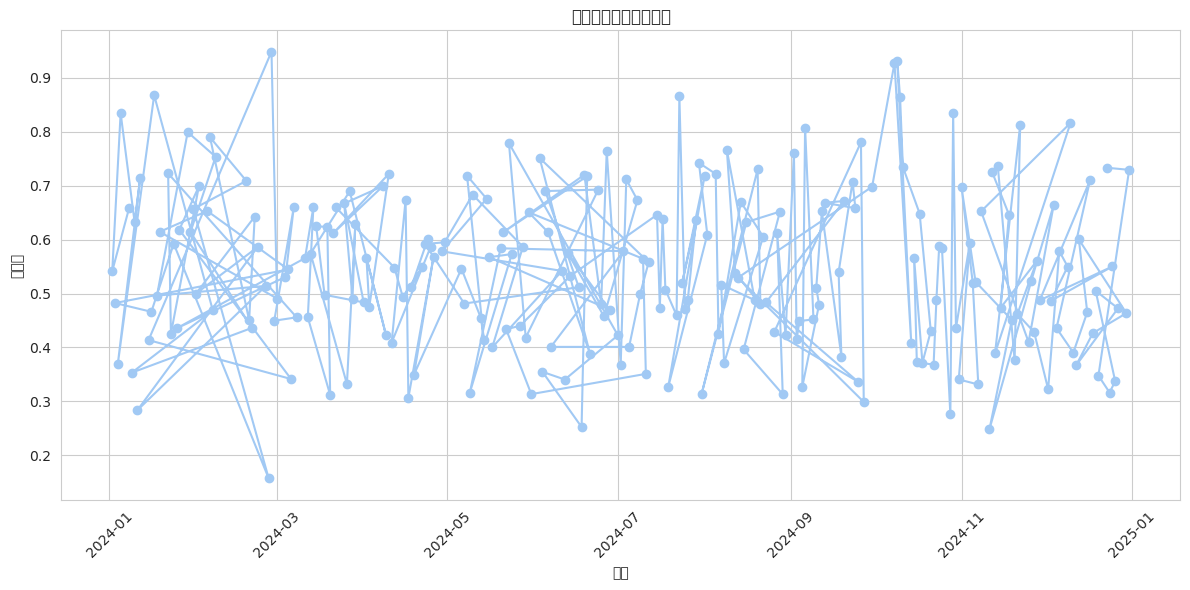


完整分类报告：
              precision    recall  f1-score   support

           0       0.81      0.51      0.63    174966
           1       0.31      0.65      0.42     59075

    accuracy                           0.55    234041
   macro avg       0.56      0.58      0.52    234041
weighted avg       0.69      0.55      0.57    234041



In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from functools import partial

# 确保时间列是 datetime 类型
gross_train_data['time'] = pd.to_datetime(gross_train_data['time'])

# 定义特征和目标变量
features = [ 
    'platform_volatility_highlow',
    'vol_rate', 
    'increase',
    'increase_validity'
]
target = 'cb'

# 筛选 2023 年的所有唯一日期并排序
unique_dates = gross_train_data[
    (gross_train_data['time'] >= '2024-01-01') & 
    (gross_train_data['time'] <= '2024-12-31')
]['time'].sort_values().unique()

# 主函数：使用多进程执行并显示进度条
def main():
    
    # 创建部分应用函数，固定 data 参数
    process_func = partial(process_timeline, data = gross_train_data)
    
    # 使用进程池执行，并通过 tqdm 显示进度条
    with Pool(64) as p:
        # 使用 imap_unordered 提高效率（结果顺序不影响）
        results = list(tqdm(
            p.imap_unordered(process_func, unique_dates),
            total=len(unique_dates),
            desc="模型训练进度",
            unit="日期"
        ))
    
    # 过滤掉 None 结果
    results = [r for r in results if r is not None]
    # 转换结果为 DataFrame
    results_df = pd.DataFrame(results)
    
    # 提取详细预测结果
    all_predictions = []
    for r in results:
        pred_df = pd.DataFrame({
            'time': [r['date']] * len(r['predictions']['actual']),
            'stock_id': r['predictions']['stock_ids'],
            'actual': r['predictions']['actual'],
            'predicted': r['predictions']['predicted']
        })
        all_predictions.append(pred_df)
    all_predictions = pd.concat(all_predictions, ignore_index=True)
    
    # 输出总体评估
    print("\n总体评估结果：")
    print(f"处理的日期数量: {len(results_df)}")
    print(f"平均准确率: {results_df['accuracy'].mean():.4f}")
    print(f"最高准确率: {results_df['accuracy'].max():.4f}")
    print(f"最低准确率: {results_df['accuracy'].min():.4f}")
    
    # 绘制准确率随时间变化的图表
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['date'], results_df['accuracy'], marker='o', linestyle='-')
    plt.title('模型准确率随时间变化')
    plt.xlabel('日期')
    plt.ylabel('准确率')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 查看完整的分类报告
    print("\n完整分类报告：")
    print(classification_report(all_predictions['actual'], all_predictions['predicted']))
    
    return results_df, all_predictions

# 确保在主模块中执行
if __name__ == '__main__':
    # 安装 tqdm（如果未安装
    results_df, predictions_df = main()

In [ ]:
    result_df = sum(results)
    print(result_df / len(results))

In [27]:
def process_timeline_forrun(timeline, data):
    timeline = pd.Timestamp(timeline)
    features = [
        'platform_length', 
        'platform_volatility_highlow', 
        'platform_volatility_open', 
        'vol_trend', 
        'vol_rate', 
        'increase',
        'increase_validity'
    ]
    target = 'cb'
    # 从共享数据中获取训练集和测试集
    train_data_X = data[data['time'] < timeline][features].reset_index(drop=True)
    train_data_y = data[data['time'] < timeline][target].reset_index(drop=True)
    test_data_X = data[data['time'] == timeline][features].reset_index(drop=True)
    test_data_y = data[data['time'] == timeline][target].reset_index(drop=True)
    data_for_return = data[data['time'] == timeline][['stock_id','daily_return']].reset_index(drop=True)
    
    # 检查测试集是否有数据
    if len(test_data_X) == 0:
        return (timeline,0)
    if len(train_data_X) == 0:
        return (timeline,0)
    # 创建并训练模型
    rf_model = RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        min_samples_split = 8,
        class_weight = 'balanced',
        random_state = 42
    )
    rf_model.fit(train_data_X, train_data_y)
    
    # 预测并评估
    y_pred = rf_model.predict(test_data_X)
    res = data_for_return.loc[y_pred == 1,'daily_return']
    if len(res) == 0:
        res = 0
    else:
        res = res.mean()
    return (timeline,res)

In [49]:
def run(start_time,end_time,gross_train_data):
    gross_train_data['time'] = pd.to_datetime(gross_train_data['time'])
    unique_dates = gross_train_data[
        (gross_train_data['time'] >= pd.Timestamp(start_time)) & 
        (gross_train_data['time'] <= pd.Timestamp(end_time))
    ]['time'].sort_values().unique()
    process_func = partial(process_timeline_forrun, data = gross_train_data)
    
    # 使用进程池执行，并通过 tqdm 显示进度条
    with Pool(64) as p:
        # 使用 imap_unordered 提高效率（结果顺序不影响）
        results = list(tqdm(
            p.imap_unordered(process_func, unique_dates),
            total=len(unique_dates),
            desc="模型训练进度",
            unit="日期"
        ))
    ret_result = pd.DataFrame(results,columns=['time', 'return']).sort_values(by = 'time').set_index('time')
    return ret_result

In [24]:
def calculate_and_plot_cumulative_return(daily_returns):
    """
    计算累计收益率并绘制折线图
    
    参数：
        daily_returns (pd.Series)：包含每日收益率的 Series，索引建议为时间序列
    
    返回：
        cumulative_returns (pd.Series)：累计收益率 Series
    """
    # 计算累计收益率，假设初始资金为 1，累计收益率计算公式：(1 + 每日收益率).cumprod() - 1
    daily_returns.index = pd.to_datetime(daily_returns.index)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    
    # 绘制累计收益率折线图
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot(title='Cumulative Returns Over Time', label='Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return cumulative_returns
    

模型训练进度: 100%|████████████████████████████████████████████████████████████████| 856/856 [1:24:29<00:00,  5.92s/日期]


<Figure size 1000x600 with 0 Axes>

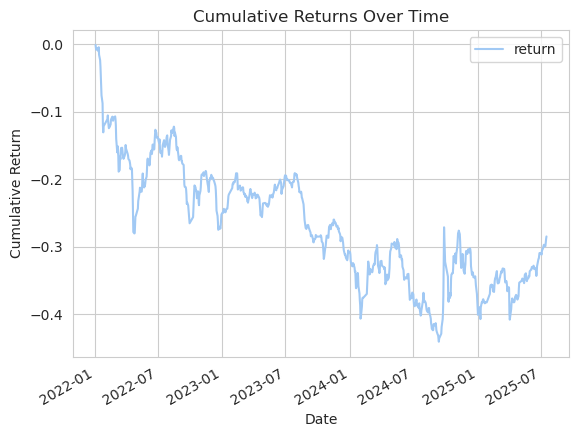

,return
time,
2022-01-04,-0.000995
2022-01-05,-0.005435
2022-01-06,-0.008164
2022-01-07,-0.006282
2022-01-10,-0.006180
...,...
2025-07-11,-0.299340
2025-07-14,-0.298951
2025-07-15,-0.293036


In [50]:
res_ret = run('2022-01-01','2025-12-31',gross_train_data)
calculate_and_plot_cumulative_return(res_ret)